# Introduction

This notebook is adapted from https://nextjournal.com/gkoehler/pytorch-mnist.
It shows how to train an artificial neural network to recognize handwritten digits.

* [X] Key notions
* [x] Jupyter notebooks

# Import Pytorch library

- [x] Open-source Python ecosystem 

In [1]:
import torch
import torchvision

# Load data


In [2]:
# Parameters (some of them will be discussed later)
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

- [x] Train and test sets

In [3]:
# Downloads and loads dataset
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
example_data.shape

torch.Size([1000, 1, 28, 28])

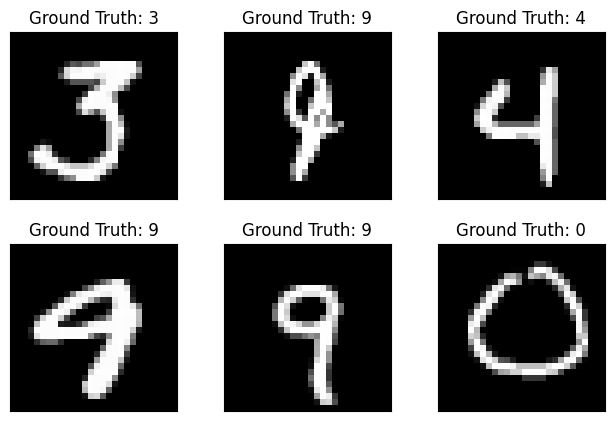

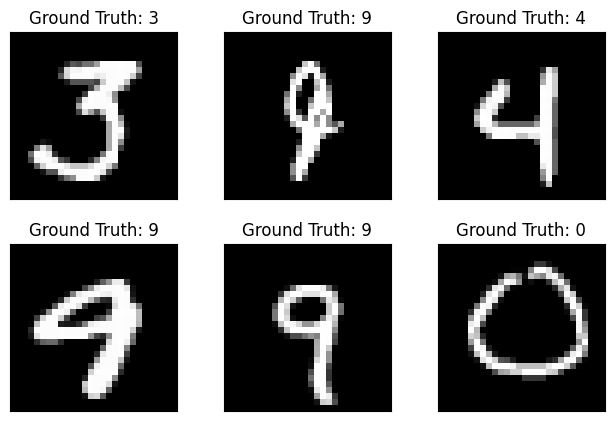

In [6]:
# Visualize some elements in the test set

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
#fig

# Build the model

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

- [x] Convolution layer: https://youtu.be/KiftWz544_8
- [x] Max pooling
- [x] Dropout regularization
- [x] Fully connected layer
- [x] Relu, softmax activation functions

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320) # reshape tensor
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [9]:
network = Net()

- [x] Optimization

In [10]:
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

# Training the model

In [11]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 2)]

- [x] loss function
- [x] backpropagation

In [12]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'results/model.pth')
      torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [13]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [14]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/tmp/ipykernel_34710/2443396204.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/home/glatard/venvs/pytorch/lib64/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313179
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.300776
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.298872
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.276723
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.241102
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.248662
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.189547
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.146399
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.107701
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.011356
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.843857
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.758839
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.672644
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.687645
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.426628
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.284204
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.318824
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.445287
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.140686
Train Epoch: 1 [12160/6

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.397987
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.223845
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.512516
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.277782
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.270144
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.196569
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.262929
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.360608
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.448026
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.277732
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.335829
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.430554
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.309067
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.367636
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.242265
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.239491
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.214331
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.471119
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.197949
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.369620


# Evaluating the model

- [x] overfitting

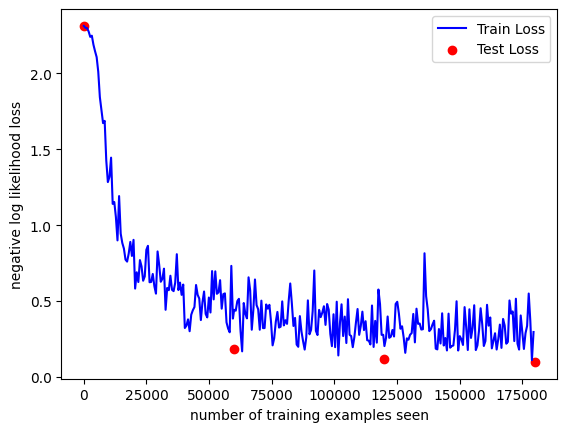

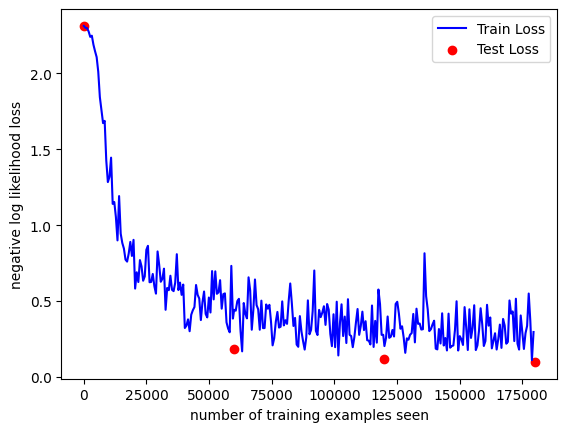

In [15]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
test_counter = test_counter[:len(test_losses)]
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [16]:
with torch.no_grad():
  output = network(example_data)

/tmp/ipykernel_34710/2443396204.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


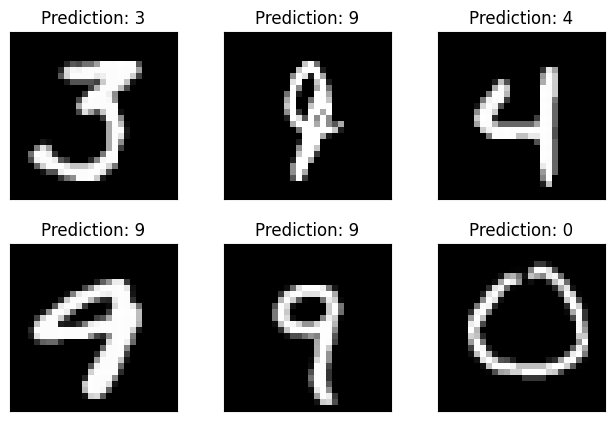

In [17]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
#fig